In [112]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import librosa.display
import os
import warnings
warnings.filterwarnings('ignore')

# Deep Learning Libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (Dense, Dropout, Activation, Flatten, 
                                   Conv2D, MaxPooling2D, BatchNormalization,
                                   LSTM, GRU, SimpleRNN, TimeDistributed,
                                   Input, Reshape, GlobalAveragePooling2D)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler , MaxAbsScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


In [113]:
# Image processing
from PIL import Image
import cv2

print("Libraries imported successfully!")
print(f"TensorFlow version: {tf.__version__}")

Libraries imported successfully!
TensorFlow version: 2.15.0


Dataset Information:
3-second features shape: (9990, 60)
30-second features shape: (1000, 60)
Columns: ['filename', 'length', 'chroma_stft_mean', 'chroma_stft_var', 'rms_mean', 'rms_var', 'spectral_centroid_mean', 'spectral_centroid_var', 'spectral_bandwidth_mean', 'spectral_bandwidth_var', 'rolloff_mean', 'rolloff_var', 'zero_crossing_rate_mean', 'zero_crossing_rate_var', 'harmony_mean', 'harmony_var', 'perceptr_mean', 'perceptr_var', 'tempo', 'mfcc1_mean', 'mfcc1_var', 'mfcc2_mean', 'mfcc2_var', 'mfcc3_mean', 'mfcc3_var', 'mfcc4_mean', 'mfcc4_var', 'mfcc5_mean', 'mfcc5_var', 'mfcc6_mean', 'mfcc6_var', 'mfcc7_mean', 'mfcc7_var', 'mfcc8_mean', 'mfcc8_var', 'mfcc9_mean', 'mfcc9_var', 'mfcc10_mean', 'mfcc10_var', 'mfcc11_mean', 'mfcc11_var', 'mfcc12_mean', 'mfcc12_var', 'mfcc13_mean', 'mfcc13_var', 'mfcc14_mean', 'mfcc14_var', 'mfcc15_mean', 'mfcc15_var', 'mfcc16_mean', 'mfcc16_var', 'mfcc17_mean', 'mfcc17_var', 'mfcc18_mean', 'mfcc18_var', 'mfcc19_mean', 'mfcc19_var', 'mfcc20_mean', 'mf

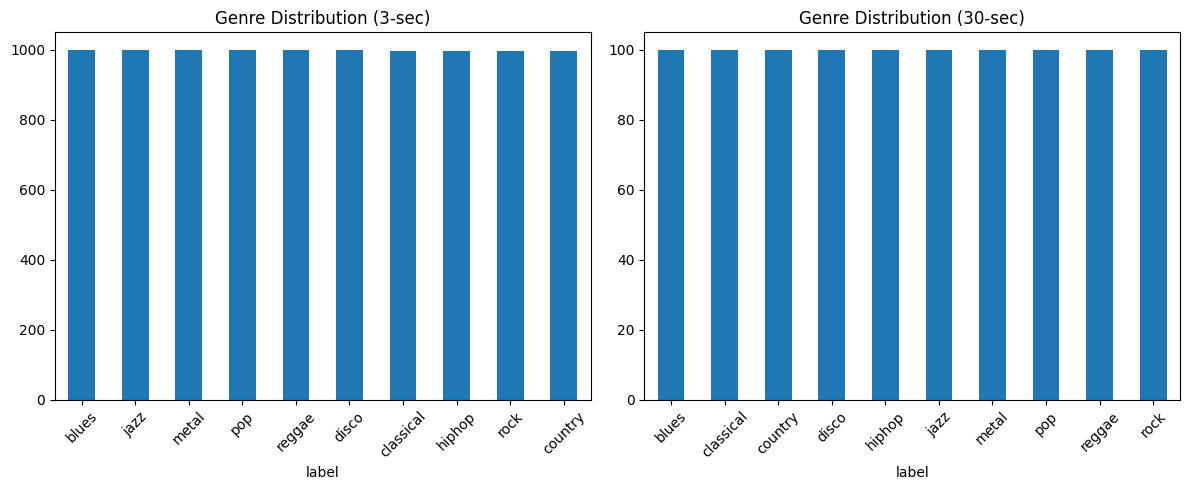

In [114]:
# ================================
# CELL 2: Data Loading and Exploration
# ================================

# Load the CSV files
features_3sec = pd.read_csv('features_3_sec.csv')
features_30sec = pd.read_csv('features_30_sec.csv')

print("Dataset Information:")
print(f"3-second features shape: {features_3sec.shape}")
print(f"30-second features shape: {features_30sec.shape}")
print(f"Columns: {features_3sec.columns.tolist()}")

# Check genres
print(f"\nGenres in 3-sec data: {features_3sec['label'].unique()}")
print(f"Genres in 30-sec data: {features_30sec['label'].unique()}")

# Genre distribution
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
features_3sec['label'].value_counts().plot(kind='bar')
plt.title('Genre Distribution (3-sec)')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
features_30sec['label'].value_counts().plot(kind='bar')
plt.title('Genre Distribution (30-sec)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [115]:
# ================================
# CELL 3: Helper Functions
# ================================

def load_and_preprocess_spectrogram(image_path, target_size=(128, 128)):
    """Load and preprocess spectrogram images"""
    try:
        img = Image.open(image_path)
        img = img.resize(target_size)
        img_array = np.array(img)
        
        # Convert to RGB if it's grayscale
        if len(img_array.shape) == 2:
            img_array = np.stack([img_array] * 3, axis=-1)
        elif img_array.shape[-1] == 4:  # RGBA
            img_array = img_array[:, :, :3]
            
        # Normalize
        img_array = img_array.astype(np.float32) / 255.0
        return img_array
    except Exception as e:
        print(f"Error loading image {image_path}: {e}")
        return None

def create_image_dataset(base_path, features_df, target_size=(128, 128)):
    """Create dataset from spectrogram images"""
    X = []
    y = []
    
    for idx, row in features_df.iterrows():
        filename = row['filename']
        label = row['label']
        # Extract genre from filename (e.g., 'blues.00000.png' -> 'blues')
        genre = filename.split('.')[0]

        parts = filename.split('.')
        print(parts)
        if len(parts) == 3 and parts[-1] == 'wav':
            filename = f"{parts[0]}{parts[1]}.wav"
        elif len(parts) == 4 and parts[-1] == 'wav':
            filename = f"{parts[0]}{parts[1]}.wav"
        print(filename)

        
        
        # Construct image path
        image_path = os.path.join(base_path, genre, filename.replace('.wav', '.png'))
        
        if os.path.exists(image_path):
            img_array = load_and_preprocess_spectrogram(image_path, target_size)
            if img_array is not None:
                X.append(img_array)
                y.append(label)
        else:
            print(f"Image not found: {image_path}")
    
    return np.array(X), np.array(y)

def prepare_sequence_data(features_df, sequence_length=10):
    """Prepare sequence data for RNN/LSTM/GRU"""
    # Select feature columns (exclude filename, length, and label)
    feature_columns = [col for col in features_df.columns 
                      if col not in ['filename', 'length', 'label']]
    
    X = features_df[feature_columns].values
    y = features_df['label'].values
    
    # Normalize features
    scaler = MaxAbsScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Create sequences by reshaping
    # For simplicity, we'll treat each sample as a sequence of features
    # In practice, you might want to create actual time sequences
    X_sequences = X_scaled.reshape(X_scaled.shape[0], 1, X_scaled.shape[1])
    
    return X_sequences, y, scaler

print("Helper functions defined successfully!")

Helper functions defined successfully!


In [116]:
# ================================
# CELL 4: Data Preparation
# ================================

# Choose which dataset to use (3-sec or 30-sec)
USE_3SEC = False  # Change to False for 30-sec data

if USE_3SEC:
    features_df = features_3sec.copy()
    duration = "3sec"
else:
    features_df = features_30sec.copy()
    duration = "30sec"

print(f"Using {duration} data with {len(features_df)} samples")

# Encode labels
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(features_df['label'])
num_classes = len(label_encoder.classes_)

print(f"Number of classes: {num_classes}")
print(f"Classes: {label_encoder.classes_}")

# Convert to categorical
y_categorical = to_categorical(encoded_labels, num_classes)


Using 30sec data with 1000 samples
Number of classes: 10
Classes: ['blues' 'classical' 'country' 'disco' 'hiphop' 'jazz' 'metal' 'pop'
 'reggae' 'rock']


Loading spectrogram images...
['blues', '00000', 'wav']
blues00000.wav
['blues', '00001', 'wav']
blues00001.wav
['blues', '00002', 'wav']
blues00002.wav
['blues', '00003', 'wav']
blues00003.wav
['blues', '00004', 'wav']
blues00004.wav
['blues', '00005', 'wav']
blues00005.wav
['blues', '00006', 'wav']
blues00006.wav
['blues', '00007', 'wav']
blues00007.wav
['blues', '00008', 'wav']
blues00008.wav
['blues', '00009', 'wav']
blues00009.wav
['blues', '00010', 'wav']
blues00010.wav
['blues', '00011', 'wav']
blues00011.wav
['blues', '00012', 'wav']
blues00012.wav
['blues', '00013', 'wav']
blues00013.wav
['blues', '00014', 'wav']
blues00014.wav
['blues', '00015', 'wav']
blues00015.wav
['blues', '00016', 'wav']
blues00016.wav
['blues', '00017', 'wav']
blues00017.wav
['blues', '00018', 'wav']
blues00018.wav
['blues', '00019', 'wav']
blues00019.wav
['blues', '00020', 'wav']
blues00020.wav
['blues', '00021', 'wav']
blues00021.wav
['blues', '00022', 'wav']
blues00022.wav
['blues', '00023', 'wav']
b

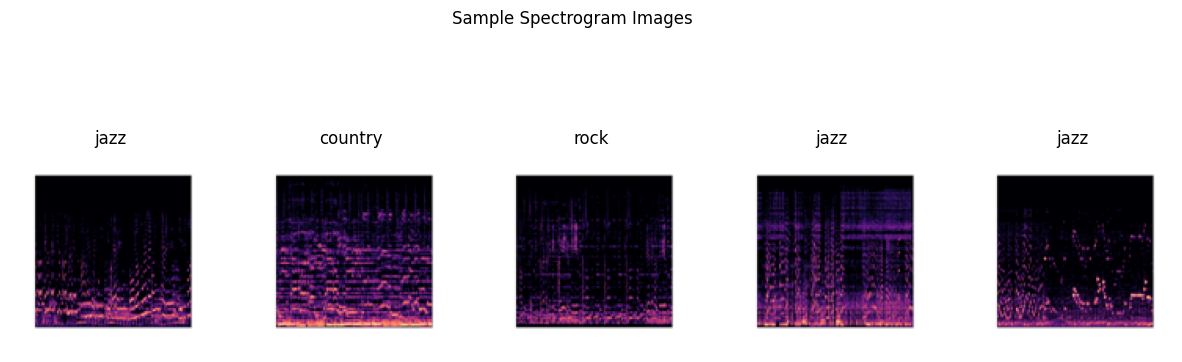

In [117]:

# ================================
# CELL 5: Load Image Data (for CNN)
# ================================

# Load spectrogram images
images_base_path = "images_original"  # Adjust path as needed
print("Loading spectrogram images...")
X_images, y_images = create_image_dataset(images_base_path, features_df)
print(X_images.shape, y_images.shape)

if len(X_images) > 0:
    print(f"Successfully loaded {len(X_images)} images")
    print(f"Image shape: {X_images[0].shape}")
    
    # Encode labels for images
    y_images_encoded = label_encoder.transform(y_images)
    y_images_categorical = to_categorical(y_images_encoded, num_classes)
    
    # Split image data
    X_img_train, X_img_test, y_img_train, y_img_test = train_test_split(
        X_images, y_images_categorical, test_size=0.2, random_state=42, stratify=y_images
    )
    
    print(f"Image training set: {X_img_train.shape}")
    print(f"Image test set: {X_img_test.shape}")
    
    # Display sample images
    plt.figure(figsize=(15, 5))
    for i in range(5):
        plt.subplot(1, 5, i+1)
        plt.imshow(X_img_train[i])
        genre_idx = np.argmax(y_img_train[i])
        plt.title(f"{label_encoder.classes_[genre_idx]}")
        plt.axis('off')
    plt.suptitle("Sample Spectrogram Images")
    plt.show()
else:
    print("No images found. Check your image paths.")


In [118]:
# ================================
# CELL 6: Prepare Feature Data (for RNN/LSTM/GRU)
# ================================

print("Preparing feature data for RNN models...")
X_features, y_features, feature_scaler = prepare_sequence_data(features_df)

print(f"Feature data shape: {X_features.shape}")
print(f"Number of features: {X_features.shape[2]}")

# Split feature data
X_feat_train, X_feat_test, y_feat_train, y_feat_test = train_test_split(
    X_features, y_categorical, test_size=0.2, random_state=42, 
    stratify=features_df['label']
)

print(f"Feature training set: {X_feat_train.shape}")
print(f"Feature test set: {X_feat_test.shape}")

Preparing feature data for RNN models...
Feature data shape: (1000, 1, 57)
Number of features: 57
Feature training set: (800, 1, 57)
Feature test set: (200, 1, 57)


In [123]:
# ================================
# CELL 7: Model 1 - CNN for Spectrograms
# ================================

def create_cnn_model(input_shape, num_classes, dropout_rate=0.3):
    """
    Enhanced CNN model with better architecture
    """
    model = Sequential([
        # First Conv Block
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape, padding='same'),
        BatchNormalization(),
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        Dropout(dropout_rate * 0.5),
        
        # Second Conv Block
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        Dropout(dropout_rate * 0.7),
        
        # Third Conv Block
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        Dropout(dropout_rate),
        
        # Fourth Conv Block
        Conv2D(256, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        GlobalAveragePooling2D(),  # Better than Flatten for reducing overfitting
        
        # Dense layers
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(dropout_rate),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(dropout_rate * 0.5),
        Dense(num_classes, activation='softmax')
    ])
    
    return model

# Create and compile CNN model
if len(X_images) > 0:
    print("Creating CNN model...")
    cnn_model = create_cnn_model(X_img_train.shape[1:], num_classes)
    
    cnn_model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    print(cnn_model.summary())
    
    cnn_callbacks = [
        EarlyStopping(patience=10, restore_best_weights=True),
        ReduceLROnPlateau(factor=0.5, patience=5),
        ModelCheckpoint('best_cnn_model.h5', save_best_only=True)
    ]
    
    print("Training CNN model...")
    cnn_history = cnn_model.fit(
        X_img_train, y_img_train,
        batch_size=32,
        epochs=50,
        validation_split=0.2,
        callbacks=cnn_callbacks,
        verbose=1
    )
    
    # Evaluate CNN
    cnn_test_loss, cnn_test_acc = cnn_model.evaluate(X_img_test, y_img_test, verbose=0)
    print(f"CNN Test Accuracy: {cnn_test_acc:.4f}")
    
    
    cnn_predictions = cnn_model.predict(X_img_test)
    cnn_pred_classes = np.argmax(cnn_predictions, axis=1)
    cnn_true_classes = np.argmax(y_img_test, axis=1)
    
    print("\nCNN Classification Report:")
    print(classification_report(cnn_true_classes, cnn_pred_classes, 
                              target_names=label_encoder.classes_))


Creating CNN model...
Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_30 (Conv2D)          (None, 128, 128, 32)      896       
                                                                 
 batch_normalization_30 (Ba  (None, 128, 128, 32)      128       
 tchNormalization)                                               
                                                                 
 conv2d_31 (Conv2D)          (None, 128, 128, 32)      9248      
                                                                 
 max_pooling2d_24 (MaxPooli  (None, 64, 64, 32)        0         
 ng2D)                                                           
                                                                 
 dropout_48 (Dropout)        (None, 64, 64, 32)        0         
                                                                 
 conv2d_32 (Conv2D)          (N

In [119]:
# ================================
# CELL 8: Model 2 - Simple RNN
# ================================

def create_rnn_model(input_shape, num_classes):
    """Create Simple RNN model"""
    model = Sequential([
        SimpleRNN(128, return_sequences=True, input_shape=input_shape),
        Dropout(0.3),
        SimpleRNN(64, return_sequences=False),
        Dropout(0.3),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    return model

print("Creating RNN model...")
rnn_model = create_rnn_model((X_feat_train.shape[1], X_feat_train.shape[2]), num_classes)

rnn_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print(rnn_model.summary())

# Train RNN
rnn_callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True),
    ReduceLROnPlateau(factor=0.5, patience=5),
    ModelCheckpoint('best_rnn_model.h5', save_best_only=True)
]

print("Training RNN model...")
rnn_history = rnn_model.fit(
    X_feat_train, y_feat_train,
    batch_size=32,
    epochs=50,
    validation_split=0.2,
    callbacks=rnn_callbacks,
    verbose=1
)

# Evaluate RNN
rnn_test_loss, rnn_test_acc = rnn_model.evaluate(X_feat_test, y_feat_test, verbose=0)
print(f"RNN Test Accuracy: {rnn_test_acc:.4f}")

Creating RNN model...
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_6 (SimpleRNN)    (None, 1, 128)            23808     
                                                                 
 dropout_37 (Dropout)        (None, 1, 128)            0         
                                                                 
 simple_rnn_7 (SimpleRNN)    (None, 64)                12352     
                                                                 
 dropout_38 (Dropout)        (None, 64)                0         
                                                                 
 dense_33 (Dense)            (None, 128)               8320      
                                                                 
 dropout_39 (Dropout)        (None, 128)               0         
                                                                 
 dense_34 (Dense)            (N

In [124]:
def create_lstm_model(input_shape, num_classes, dropout_rate=0.3):
    """
    Enhanced LSTM model with bidirectional layers
    """
    from tensorflow.keras.layers import Bidirectional
    
    model = Sequential([
        Bidirectional(LSTM(128, return_sequences=True, dropout=dropout_rate), 
                     input_shape=input_shape),
        BatchNormalization(),
        
        Bidirectional(LSTM(64, return_sequences=True, dropout=dropout_rate)),
        BatchNormalization(),
        
        LSTM(32, return_sequences=False, dropout=dropout_rate),
        BatchNormalization(),
        
        Dense(128, activation='relu'),
        Dropout(dropout_rate),
        Dense(64, activation='relu'),
        Dropout(dropout_rate * 0.5),
        Dense(num_classes, activation='softmax')
    ])
    
    return model

print("Creating LSTM model...")
lstm_model = create_lstm_model((X_feat_train.shape[1], X_feat_train.shape[2]), num_classes)

lstm_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print(lstm_model.summary())

# Train LSTM
lstm_callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True),
    ReduceLROnPlateau(factor=0.5, patience=5),
    ModelCheckpoint('best_lstm_model.h5', save_best_only=True)
]

print("Training LSTM model...")
lstm_history = lstm_model.fit(
    X_feat_train, y_feat_train,
    batch_size=32,
    epochs=50,
    validation_split=0.2,
    callbacks=lstm_callbacks,
    verbose=1
)

# Evaluate LSTM
lstm_test_loss, lstm_test_acc = lstm_model.evaluate(X_feat_test, y_feat_test, verbose=0)
print(f"LSTM Test Accuracy: {lstm_test_acc:.4f}")

Creating LSTM model...
Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirection  (None, 1, 256)            190464    
 al)                                                             
                                                                 
 batch_normalization_36 (Ba  (None, 1, 256)            1024      
 tchNormalization)                                               
                                                                 
 bidirectional_1 (Bidirecti  (None, 1, 128)            164352    
 onal)                                                           
                                                                 
 batch_normalization_37 (Ba  (None, 1, 128)            512       
 tchNormalization)                                               
                                                                 
 lstm_14 (LSTM)              (

In [129]:
# ================================
# CELL 10: Model 4 - GRU
# ================================

def create_gru_model(input_shape, num_classes, dropout_rate=0.3):
    """
    Enhanced GRU model with attention mechanism
    """
    from tensorflow.keras.layers import Bidirectional, Attention, Concatenate
    
    # Input layer
    input_layer = Input(shape=input_shape)
    
    # Bidirectional GRU layers
    gru1 = Bidirectional(GRU(128, return_sequences=True, dropout=dropout_rate))(input_layer)
    gru1_bn = BatchNormalization()(gru1)
    
    gru2 = Bidirectional(GRU(64, return_sequences=True, dropout=dropout_rate))(gru1_bn)
    gru2_bn = BatchNormalization()(gru2)
    
    # Final GRU layer
    gru3 = GRU(32, return_sequences=False, dropout=dropout_rate)(gru2_bn)
    gru3_bn = BatchNormalization()(gru3)
    
    # Dense layers
    dense1 = Dense(128, activation='relu')(gru3_bn)
    dropout1 = Dropout(dropout_rate)(dense1)
    dense2 = Dense(64, activation='relu')(dropout1)
    dropout2 = Dropout(dropout_rate * 0.5)(dense2)
    
    # Output layer
    output = Dense(num_classes, activation='softmax')(dropout2)
    
    model = Model(inputs=input_layer, outputs=output)
    return model

print("Creating GRU model...")
gru_model = create_gru_model((X_feat_train.shape[1], X_feat_train.shape[2]), num_classes)

gru_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print(gru_model.summary())

# Train GRU
gru_callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True),
    ReduceLROnPlateau(factor=0.5, patience=5),
    ModelCheckpoint('best_gru_model.h5', save_best_only=True)
]

print("Training GRU model...")
gru_history = gru_model.fit(
    X_feat_train, y_feat_train,
    batch_size=32,
    epochs=50,
    validation_split=0.2,
    callbacks=gru_callbacks,
    verbose=1
)

# Evaluate GRU
gru_test_loss, gru_test_acc = gru_model.evaluate(X_feat_test, y_feat_test, verbose=0)
print(f"GRU Test Accuracy: {gru_test_acc:.4f}")


Creating GRU model...
Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 1, 57)]           0         
                                                                 
 bidirectional_10 (Bidirect  (None, 1, 256)            143616    
 ional)                                                          
                                                                 
 batch_normalization_51 (Ba  (None, 1, 256)            1024      
 tchNormalization)                                               
                                                                 
 bidirectional_11 (Bidirect  (None, 1, 128)            123648    
 ional)                                                          
                                                                 
 batch_normalization_52 (Ba  (None, 1, 128)            512       
 tchNormalization)                  

In [122]:
# ================================
# CELL 11: Model 5 - CNN + LSTM Hybrid
# ================================

def create_cnn_lstm_model(input_shape, num_classes):
    """Create CNN + LSTM hybrid model"""
    # CNN part for feature extraction
    cnn_input = Input(shape=input_shape)
    x = Conv2D(64, (3, 3), activation='tanh')(cnn_input)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    
    x = Conv2D(128, (3, 3), activation='tanh')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    
    x = Conv2D(256, (3, 3), activation='tanh')(x)
    x = BatchNormalization()(x)
    x = GlobalAveragePooling2D()(x)
    
    # Reshape for LSTM
    x = Reshape((1, 256))(x)
    
    # LSTM part
    x = LSTM(64, return_sequences=False)(x)
    x = Dropout(0.6)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    output = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=cnn_input, outputs=output)
    return model

# Create and train CNN+LSTM model (if images are available)
if len(X_images) > 0:
    print("Creating CNN+LSTM hybrid model...")
    cnn_lstm_model = create_cnn_lstm_model(X_img_train.shape[1:], num_classes)
    
    cnn_lstm_model.compile(
        optimizer=Adam(learning_rate=0.01),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    print(cnn_lstm_model.summary())
    
    # Train CNN+LSTM
    cnn_lstm_callbacks = [
        EarlyStopping(patience=10, restore_best_weights=True),
        ReduceLROnPlateau(factor=0.5, patience=5),
        ModelCheckpoint('best_cnn_lstm_model.h5', save_best_only=True)
    ]
    
    print("Training CNN+LSTM model...")
    cnn_lstm_history = cnn_lstm_model.fit(
        X_img_train, y_img_train,
        batch_size=32,
        epochs=50,
        validation_split=0.2,
        callbacks=cnn_lstm_callbacks,
        verbose=1
    )
    
    # Evaluate CNN+LSTM
    cnn_lstm_test_loss, cnn_lstm_test_acc = cnn_lstm_model.evaluate(X_img_test, y_img_test, verbose=0)
    print(f"CNN+LSTM Test Accuracy: {cnn_lstm_test_acc:.4f}")

Creating CNN+LSTM hybrid model...
Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d_27 (Conv2D)          (None, 126, 126, 64)      1792      
                                                                 
 batch_normalization_27 (Ba  (None, 126, 126, 64)      256       
 tchNormalization)                                               
                                                                 
 max_pooling2d_22 (MaxPooli  (None, 63, 63, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_28 (Conv2D)          (None, 61, 61, 128)       73856     
                                                                 
 batch_normalization_28 (

KeyboardInterrupt: 

In [95]:
# Collect all results
results = {
    'RNN': rnn_test_acc,
    'LSTM': lstm_test_acc,
    'GRU': gru_test_acc
}

if len(X_images) > 0:
    results['CNN'] = cnn_test_acc
    results['CNN+LSTM'] = cnn_lstm_test_acc

print("\n" + "="*50)
print("FINAL RESULTS COMPARISON")
print("="*50)
for model_name, accuracy in results.items():
    print(f"{model_name}: {accuracy:.4f} ({accuracy*100:.2f}%)")


FINAL RESULTS COMPARISON
RNN: 0.7150 (71.50%)
LSTM: 0.7400 (74.00%)
GRU: 0.7700 (77.00%)
CNN: 0.1000 (10.00%)
CNN+LSTM: 0.2900 (29.00%)


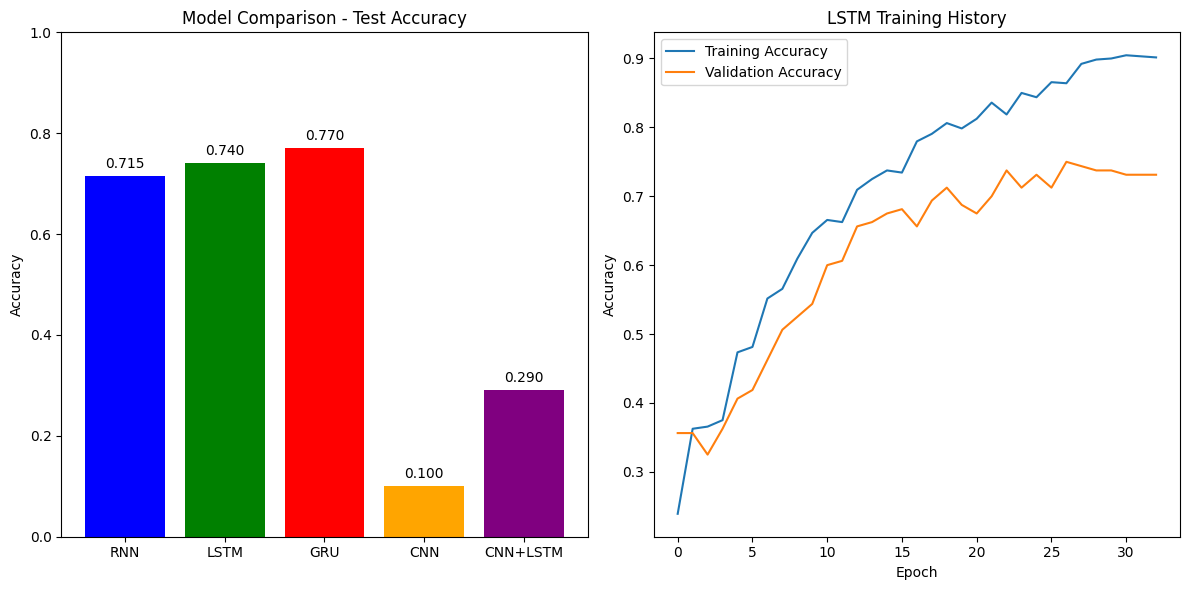

In [96]:
# Plot results
plt.figure(figsize=(12, 6))
models = list(results.keys())
accuracies = list(results.values())

plt.subplot(1, 2, 1)
bars = plt.bar(models, accuracies, color=['blue', 'green', 'red', 'orange', 'purple'][:len(models)])
plt.title('Model Comparison - Test Accuracy')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{acc:.3f}', ha='center', va='bottom')

# Plot training history for LSTM (as example)
plt.subplot(1, 2, 2)
plt.plot(lstm_history.history['accuracy'], label='Training Accuracy')
plt.plot(lstm_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('LSTM Training History')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()



Best performing model: GRU with accuracy: 0.7700
7/7 [==============================] - 1s 2ms/step


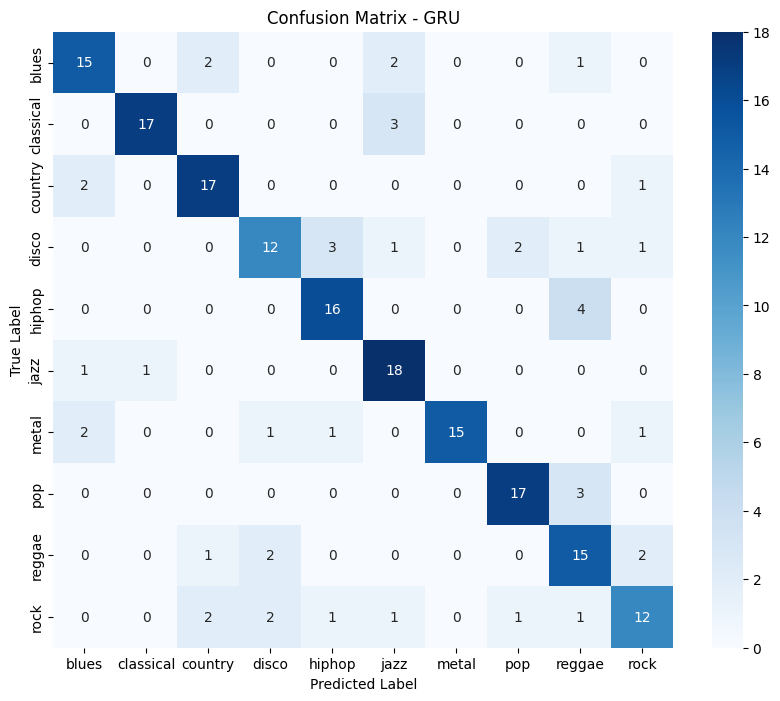


Detailed Classification Report - GRU:
              precision    recall  f1-score   support

       blues       0.75      0.75      0.75        20
   classical       0.94      0.85      0.89        20
     country       0.77      0.85      0.81        20
       disco       0.71      0.60      0.65        20
      hiphop       0.76      0.80      0.78        20
        jazz       0.72      0.90      0.80        20
       metal       1.00      0.75      0.86        20
         pop       0.85      0.85      0.85        20
      reggae       0.60      0.75      0.67        20
        rock       0.71      0.60      0.65        20

    accuracy                           0.77       200
   macro avg       0.78      0.77      0.77       200
weighted avg       0.78      0.77      0.77       200



In [97]:
# ================================
# CELL 13: Detailed Evaluation
# ================================

# Detailed evaluation for best performing model
best_model_name = max(results, key=results.get)
print(f"\nBest performing model: {best_model_name} with accuracy: {results[best_model_name]:.4f}")

# Get predictions from best model
if best_model_name == 'CNN' and len(X_images) > 0:
    best_predictions = cnn_model.predict(X_img_test)
    y_true = np.argmax(y_img_test, axis=1)
elif best_model_name == 'CNN+LSTM' and len(X_images) > 0:
    best_predictions = cnn_lstm_model.predict(X_img_test)
    y_true = np.argmax(y_img_test, axis=1)
elif best_model_name == 'RNN':
    best_predictions = rnn_model.predict(X_feat_test)
    y_true = np.argmax(y_feat_test, axis=1)
elif best_model_name == 'LSTM':
    best_predictions = lstm_model.predict(X_feat_test)
    y_true = np.argmax(y_feat_test, axis=1)
elif best_model_name == 'GRU':
    best_predictions = gru_model.predict(X_feat_test)
    y_true = np.argmax(y_feat_test, axis=1)

y_pred = np.argmax(best_predictions, axis=1)
# Confusion Matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_encoder.classes_, 
            yticklabels=label_encoder.classes_)
plt.title(f'Confusion Matrix - {best_model_name}')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Classification Report
print(f"\nDetailed Classification Report - {best_model_name}:")
print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))


In [81]:
# ================================
# CELL 14: Model Saving and Loading
# ================================

# Save all models
model_info = {
    'rnn_model': rnn_model,
    'lstm_model': lstm_model,
    'gru_model': gru_model
}

if len(X_images) > 0:
    model_info['cnn_model'] = cnn_model
    model_info['cnn_lstm_model'] = cnn_lstm_model

print("Saving models...")
for name, model in model_info.items():
    model.save(f'{name}.h5')
    print(f"Saved {name}.h5")

# Save label encoder and scaler
import pickle
with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)
    
with open('feature_scaler.pkl', 'wb') as f:
    pickle.dump(feature_scaler, f)

print("Saved label_encoder.pkl and feature_scaler.pkl")

print("\n" + "="*50)
print("PROJECT COMPLETED SUCCESSFULLY!")
print("="*50)
print("Models trained and saved:")
for name in model_info.keys():
    print(f"- {name}.h5")
print("- label_encoder.pkl")
print("- feature_scaler.pkl")

Saving models...
Saved rnn_model.h5
Saved lstm_model.h5
Saved gru_model.h5
Saved cnn_model.h5
Saved cnn_lstm_model.h5
Saved label_encoder.pkl and feature_scaler.pkl

PROJECT COMPLETED SUCCESSFULLY!
Models trained and saved:
- rnn_model.h5
- lstm_model.h5
- gru_model.h5
- cnn_model.h5
- cnn_lstm_model.h5
- label_encoder.pkl
- feature_scaler.pkl
